<h1> Bone Fracture Detection with X-ray images </h1>

<h3> Sanjay Girish Dialani </h3>
<h3> X22102442@student.ncirl.ie  </h3>
<h3> National College of Ireland </h3>

<h3> Akimuddin Aslam Shaikh </h3>
<h3> National College of Ireland  </h3>
<h3> X22123245@student.ncirl.ie  </h3>

In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.models import * 
from tensorflow.keras.preprocessing import image
import cv2
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

## Exploratory Data An alysis

### Class Balance Analysis

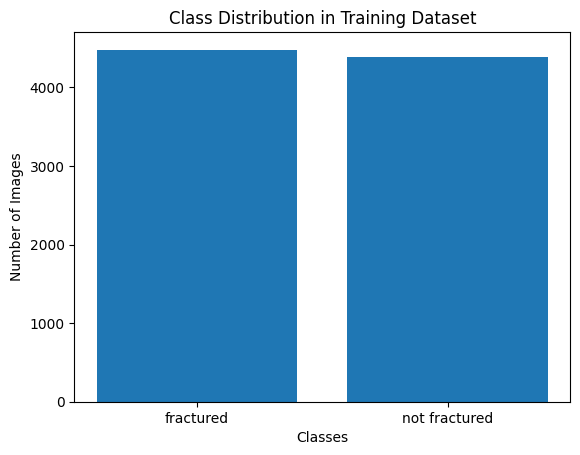

In [2]:

# Path to the dataset folders
train_folder = './Data/train'
validation_folder = './Data/val'

# List the classes
classes = os.listdir(train_folder)

# Initialize counters for each class
class_counts = {cls: 0 for cls in classes}

# Iterate through the training dataset
for cls in classes:
    cls_folder = os.path.join(train_folder, cls)
    class_counts[cls] = len(os.listdir(cls_folder))

# Plot class distribution
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Class Distribution in Training Dataset')
plt.show()



### Sample Image Display

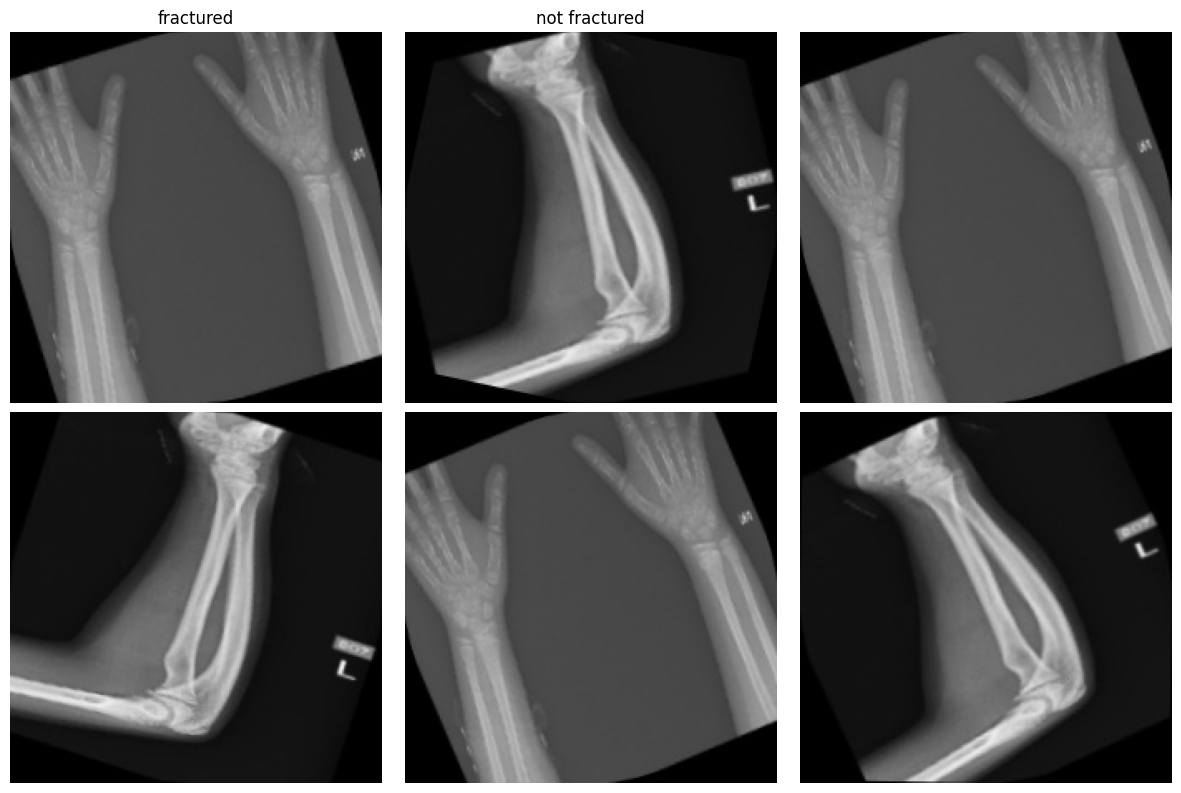

Sample Image Dimensions: 224 x 224


In [3]:

# Display sample images
num_samples = 3
plt.figure(figsize=(12, 8))
for cls in classes:
    cls_folder = os.path.join(train_folder, cls)
    sample_images = os.listdir(cls_folder)[:num_samples]
    for i, image_filename in enumerate(sample_images):
        image_path = os.path.join(cls_folder, image_filename)
        image = Image.open(image_path)
        plt.subplot(len(classes), num_samples, len(classes) * i + (classes.index(cls) + 1))
        plt.imshow(image)
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.tight_layout()
plt.show()

# Get sample image dimensions
sample_image_path = os.path.join(train_folder, classes[0], os.listdir(os.path.join(train_folder, classes[0]))[0])
sample_image = Image.open(sample_image_path)
image_width, image_height = sample_image.size

print(f"Sample Image Dimensions: {image_width} x {image_height}")

## Data Preparation

### Image Augmentation

In [7]:
from tensorflow.keras.preprocessing import image

train_datagen = image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)

val_datagen = image.ImageDataGenerator(    
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)


In [8]:
train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size = (224,224),
    batch_size = 4,
    class_mode = 'binary')
validation_generator = val_datagen.flow_from_directory(
    validation_folder,
    target_size = (224,224),
    batch_size = 4,
    shuffle=True,
    class_mode = 'binary')

Found 8863 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


## Modeling

### 1. CNN

In [9]:
base_model = tf.keras.applications.EfficientNetB3(weights='imagenet', input_shape=(224,224,3), include_top=False)

for layer in base_model.layers:
    layer.trainable=False
model = Sequential()
model.add(base_model)
model.add(GaussianNoise(0.25))
model.add(GlobalAveragePooling2D())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(GaussianNoise(0.25))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 7, 7, 1536)       10783535  
                                                                 
 gaussian_noise (GaussianNoi  (None, 7, 7, 1536)       0         
 se)                                                             
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               786944    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                        

In [10]:
import json
import numpy as np
from keras.callbacks import Callback

# Define a custom callback to capture and save training history
class CustomHistoryCallback(Callback):
    def __init__(self, filename):
        self.filename = filename
        self.history_dict = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

    def on_epoch_end(self, epoch, logs=None):
        self.history_dict['loss'].append(logs.get('loss'))
        self.history_dict['accuracy'].append(logs.get('accuracy'))
        self.history_dict['val_loss'].append(logs.get('val_loss'))
        self.history_dict['val_accuracy'].append(logs.get('val_accuracy'))
        
        # Save the history information to a JSON file
        with open(self.filename, 'w') as history_file:
            json.dump(self.history_dict, history_file)

# Create an instance of the custom callback
custom_callback = CustomHistoryCallback('training_history.json')



In [12]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy','Precision','Recall','AUC'])

In [13]:
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    steps_per_epoch=50,
    callbacks=[custom_callback]  # Use the custom callback here
)

Epoch 1/15
50/50 [==============================] - 78s 1s/step - loss: 1.0612 - accuracy: 0.5900 - precision: 0.6139 - recall: 0.5905 - auc: 0.6538 - val_loss: 1.2404 - val_accuracy: 0.4817 - val_precision: 0.4344 - val_recall: 0.9792 - val_auc: 0.6471
Epoch 2/15
50/50 [==============================] - 59s 1s/step - loss: 0.8532 - accuracy: 0.6300 - precision: 0.6667 - recall: 0.6296 - auc: 0.6919 - val_loss: 0.8768 - val_accuracy: 0.5567 - val_precision: 0.4726 - val_recall: 0.9333 - val_auc: 0.6887
Epoch 3/15
50/50 [==============================] - 61s 1s/step - loss: 0.6990 - accuracy: 0.6750 - precision: 0.6863 - recall: 0.6796 - auc: 0.7455 - val_loss: 0.6913 - val_accuracy: 0.6333 - val_precision: 0.5735 - val_recall: 0.3250 - val_auc: 0.7502
Epoch 4/15
50/50 [==============================] - 63s 1s/step - loss: 0.6302 - accuracy: 0.6800 - precision: 0.6126 - recall: 0.7640 - auc: 0.7889 - val_loss: 0.6924 - val_accuracy: 0.6717 - val_precision: 0.5696 - val_recall: 0.7333 - 

In [14]:
model.evaluate(train_generator)

2216/2216 [==============================] - 687s 310ms/step - loss: 0.3708 - accuracy: 0.8295 - precision: 0.8777 - recall: 0.7614 - auc: 0.9228


[0.370813250541687,
 0.8295159935951233,
 0.8776959776878357,
 0.761350691318512,
 0.9227522611618042]

In [15]:
model.evaluate(validation_generator)

150/150 [==============================] - 48s 322ms/step - loss: 0.6811 - accuracy: 0.6733 - precision: 0.5965 - recall: 0.5667 - auc: 0.7480


[0.6811441779136658,
 0.6733333468437195,
 0.5964912176132202,
 0.5666666626930237,
 0.7479629516601562]

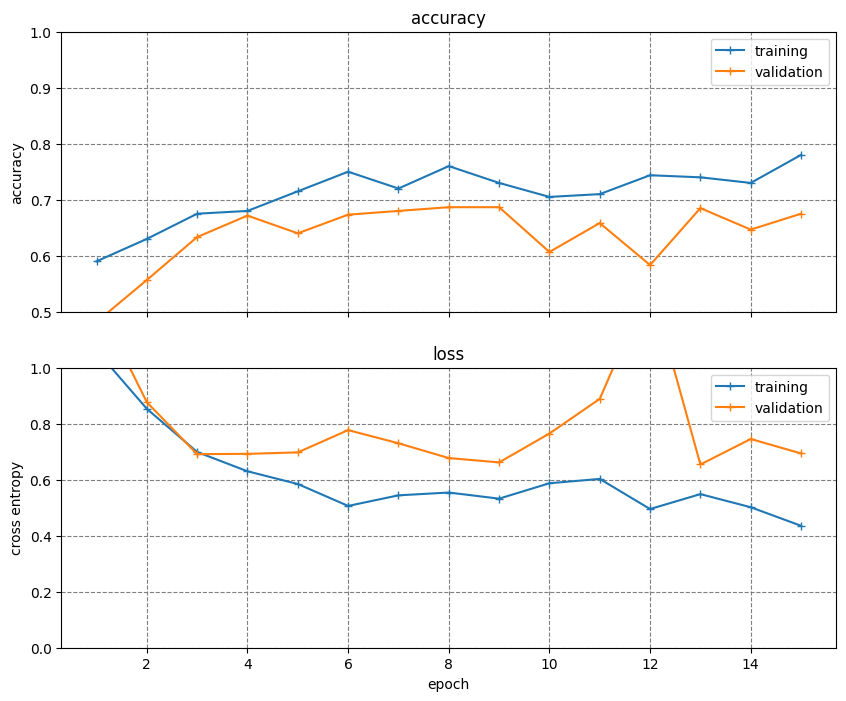

In [16]:
# training_loss = history.history['loss']
# validation_loss = history.history['val_loss']

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,8), sharex=True)

x_plot = range(1, len(val_loss) + 1)

ax[0].plot(x_plot, acc, '+-', label='training')
ax[0].plot(x_plot, val_acc, '+-', label='validation')
ax[0].legend()
ax[0].set_ylabel('accuracy')
ax[0].set_ylim(0.5, 1)
ax[0].grid(ls='--', c='C7')
ax[0].set_title('accuracy')

ax[1].plot(x_plot, loss, '+-', label='training')
ax[1].plot(x_plot, val_loss, '+-', label='validation')
ax[1].legend()
ax[1].set_ylabel('cross entropy')
ax[1].set_ylim(0, 1)
ax[1].grid(ls='--', c='C7')
ax[1].set_title('loss')
ax[1].set_xlabel('epoch')

plt.show()

150/150 [==============================] - 46s 290ms/step


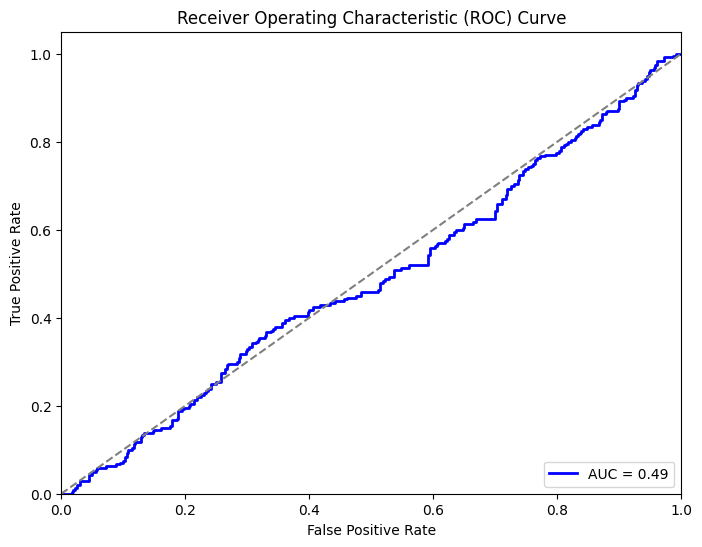

In [17]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Predict probabilities on validation data
y_pred_prob = model.predict(validation_generator)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(validation_generator.labels, y_pred_prob)

# Calculate AUC
roc_auc = roc_auc_score(validation_generator.labels, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


### 2. Random Forest with Edge Detection

In [18]:
import os
import cv2
import numpy as np
import random
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
#import matplotlib.pyplot as pltimport matplotlib
import matplotlib
import matplotlib.pyplot as plt

In [19]:
class1_folder = './Data/train/fractured'
class2_folder = './Data/train/not fractured'

In [20]:
# Function to load images from a folder
def load_images_from_folder(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        image = cv2.imread(image_path)
        if image is not None:
            images.append(image)
    return images


In [21]:
class1_images = load_images_from_folder(class1_folder)
class2_images = load_images_from_folder(class2_folder)

Class 1 sample images:


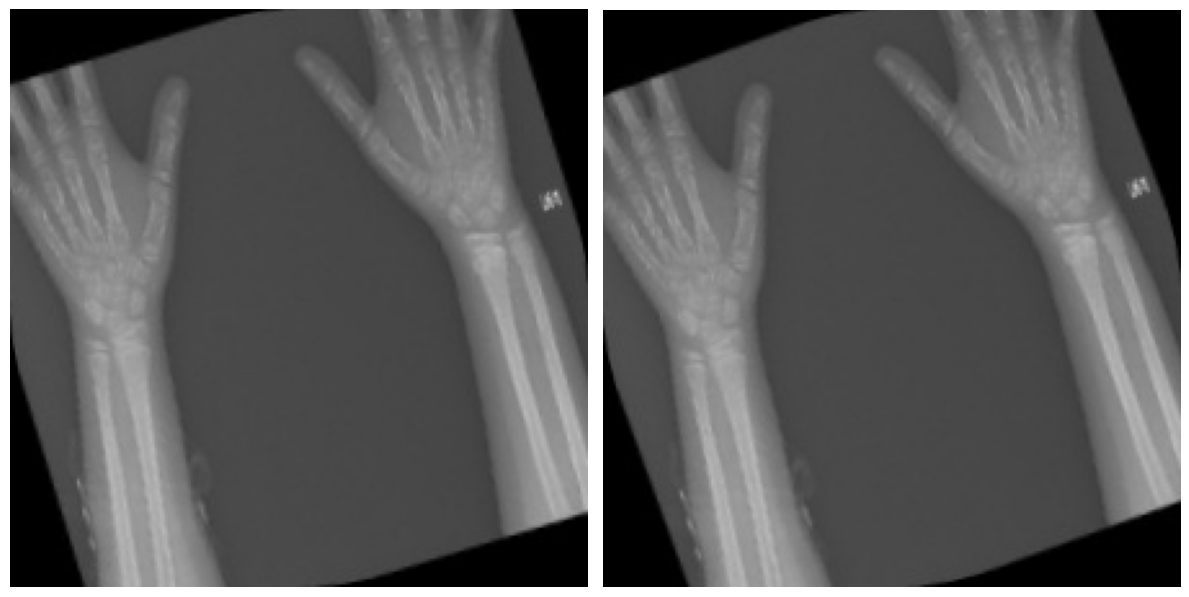


Class 2 sample images:


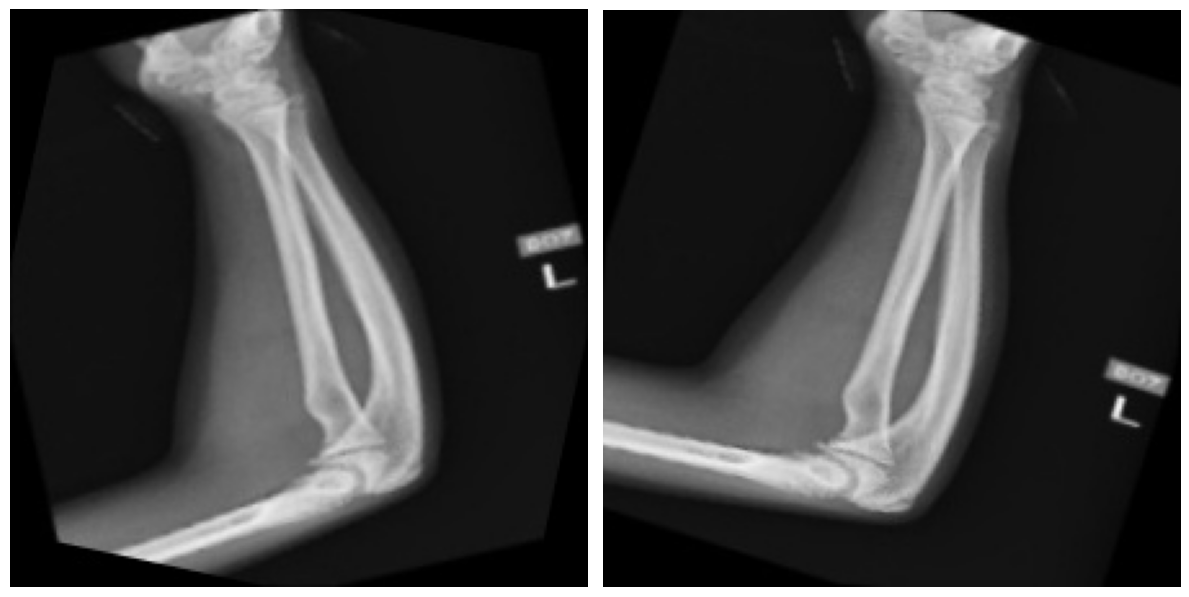

In [22]:
def display_sample_images(images, num_images=2):
    fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(12, 8))
    
    for i in range(num_images):
        axes[i].imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        axes[i].axis('off')
        
    plt.tight_layout()
    plt.show()

# Display sample images using Matplotlib
print("Class 1 sample images:")
display_sample_images(class1_images)

print("\nClass 2 sample images:")
display_sample_images(class2_images)

In [23]:
def apply_edge_detection(image):
    # Apply edge detection algorithm (e.g., Canny edge detection)
    edges = cv2.Canny(image, 100, 200)
    return edges

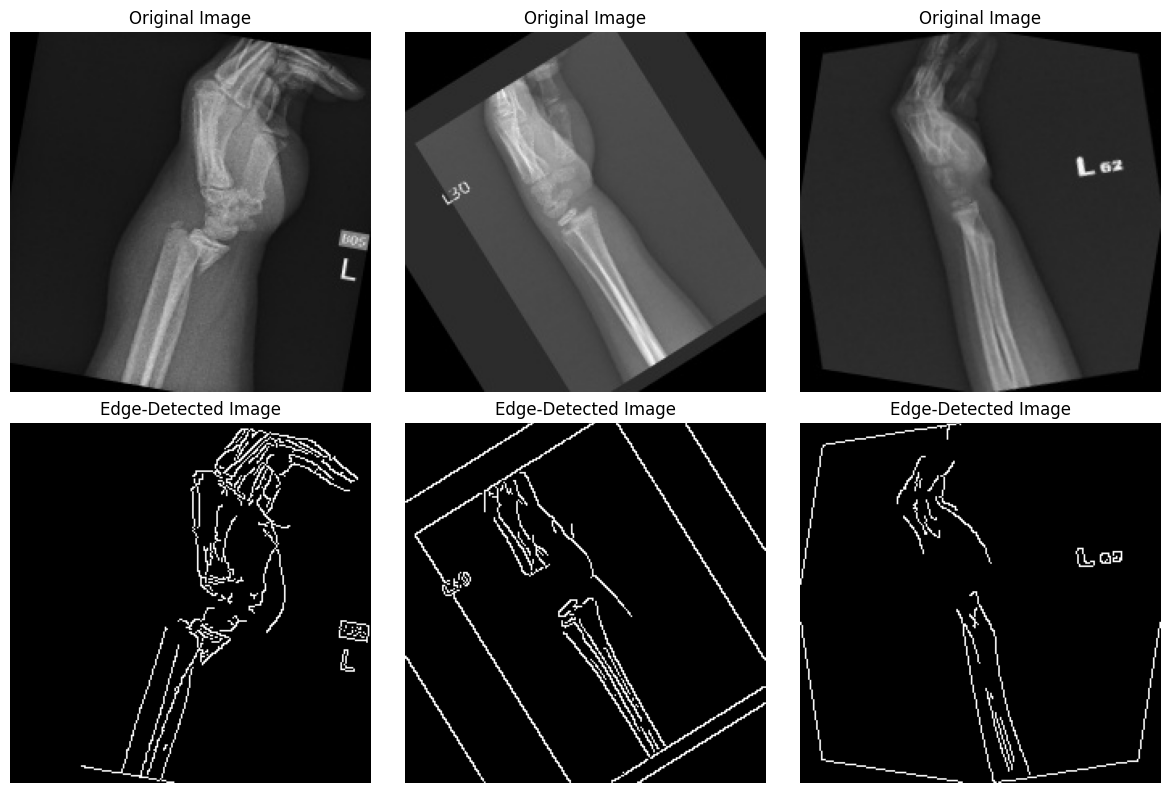

In [32]:
def display_random_images(images, num_images=3):
    random_images = random.sample(images, num_images)
    plt.figure(figsize=(12, 8))
    
    for i, image in enumerate(random_images):
        # Original image
        original_image = image
        
        # Apply edge detection
        edge_detected_image = apply_edge_detection(original_image)
        
        # Plotting original and edge-detected images side by side
        plt.subplot(2, num_images, i+1)
        plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title('Original Image')
        
        plt.subplot(2, num_images, num_images+i+1)
        plt.imshow(edge_detected_image, cmap='gray')
        plt.axis('off')
        plt.title('Edge-Detected Image')
    
    plt.tight_layout()
    plt.show()

# Display random original and edge-detected images
display_random_images(class1_images, num_images=3)

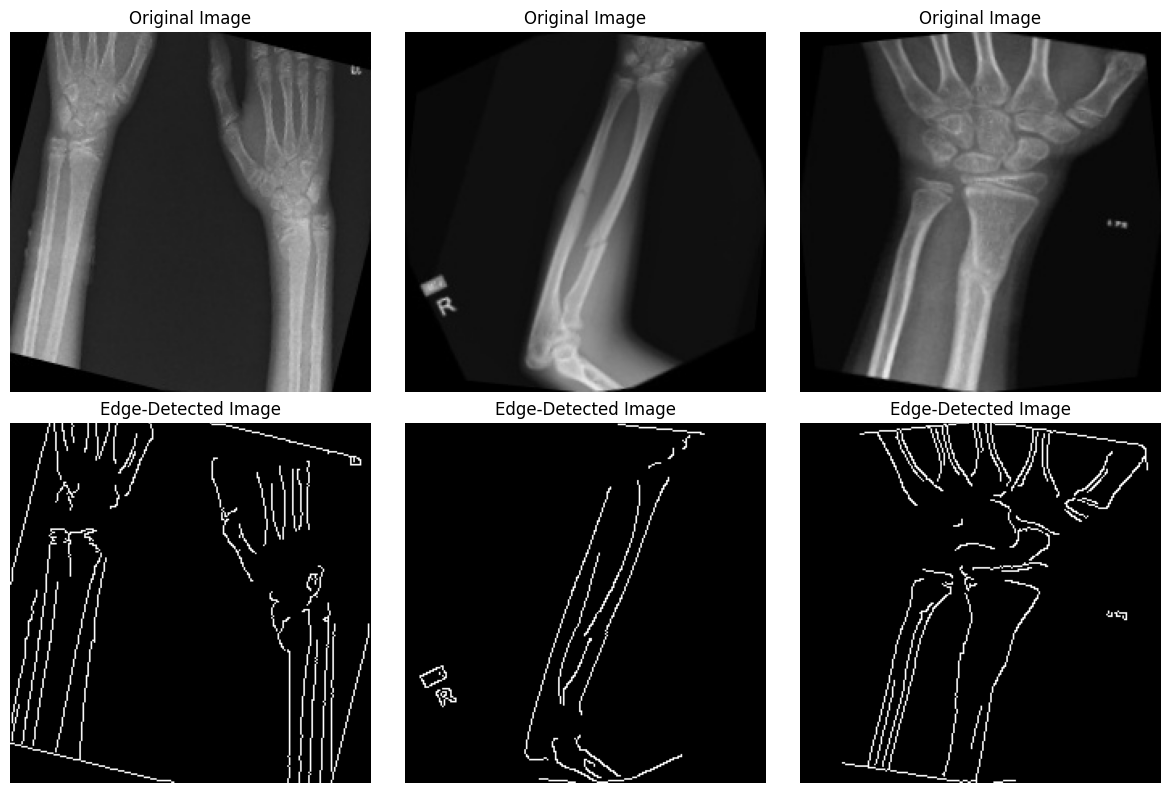

In [36]:
# Combine images from both classes
images = class1_images + class2_images

# Display random original and edge-detected images
display_random_images(class1_images, num_images=3)


In [37]:
# Apply edge detection to all images
class1_edges = [apply_edge_detection(image) for image in class1_images]
class2_edges = [apply_edge_detection(image) for image in class2_images]

# Combine edge-detected images and labels
X = np.array(class1_edges + class2_edges)
y = np.array([1] * len(class1_edges) + [0] * len(class2_edges))

C:\Users\amrit\AppData\Local\Temp\ipykernel_19124\4120274313.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(class1_edges + class2_edges)


In [38]:
def resize_images(images, target_shape):
    resized_images = []
    for image in images:
        resized_image = cv2.resize(image, target_shape, interpolation=cv2.INTER_CUBIC)
        resized_images.append(resized_image)
    return resized_images

In [39]:
target_shape = (256, 256)
class1_edges_resized = resize_images(class1_edges, target_shape)
class2_edges_resized = resize_images(class2_edges, target_shape)

In [40]:
X = np.array(class1_edges_resized + class2_edges_resized)
y = np.array([1] * len(class1_edges_resized) + [0] * len(class2_edges_resized))
X = X.reshape(X.shape[0], -1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [42]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))


Accuracy: 0.8781725888324873
Precision: 0.8936416184971099
Recall: 0.8617614269788183
F1: 0.877412031782066


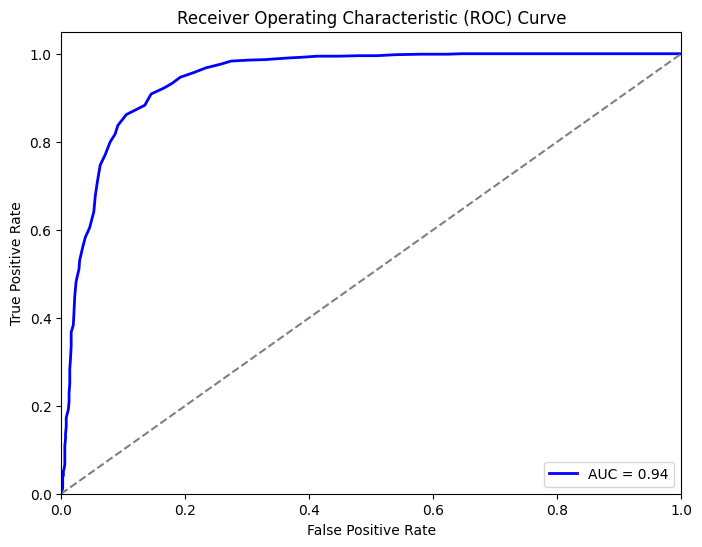

AUC-ROC: 0.9448224166806657


In [46]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming you have already trained your Random Forest classifier and obtained predicted labels
y_pred_prob = model.predict_proba(X_test)[:, 1]  # Predicted probabilities for positive class

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

# Compute AUC-ROC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print("AUC-ROC:", roc_auc)


### 3. CNN with Edge Detection

In [43]:

input_shape = (224, 224, 3)  # Input shape for the model
batch_size = 32
epochs = 15

In [44]:

# Load and preprocess images
def load_and_preprocess_images(folder_path, label):
    images = []
    for image_filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_filename)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (input_shape[0], input_shape[1]))
        images.append(image)
    labels = [label] * len(images)
    return images, labels

class1_images, class1_labels = load_and_preprocess_images(class1_folder, label=0)
class2_images, class2_labels = load_and_preprocess_images(class2_folder, label=1)

# Combine the datasets and labels
all_images = class1_images + class2_images
all_labels = class1_labels + class2_labels


In [45]:

# Apply Canny edge detection
def apply_canny_edge_detection(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, threshold1=100, threshold2=200)
    edges_rgb = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)
    return edges_rgb

canny_images = [apply_canny_edge_detection(image) for image in all_images]


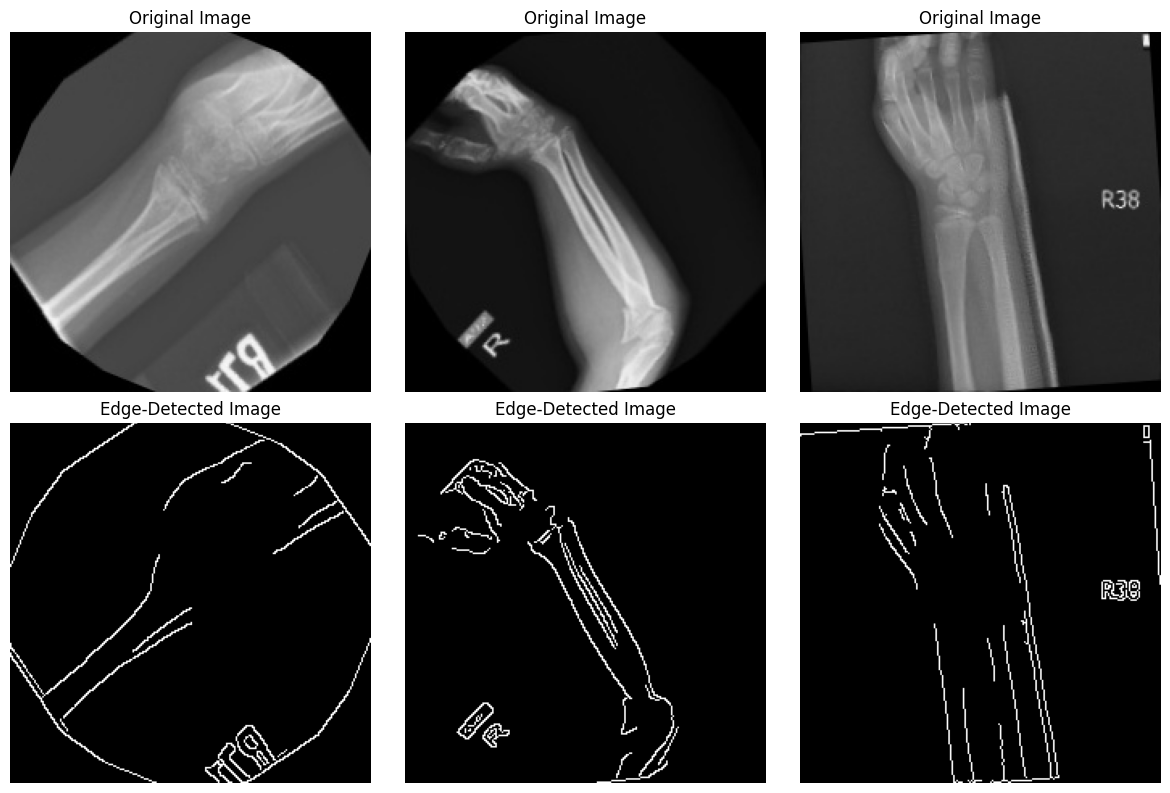

In [47]:

def display_random_images(images, num_images=3):
    random_images = random.sample(images, num_images)
    plt.figure(figsize=(12, 8))
    
    for i, image in enumerate(random_images):
        original_image = image
        edge_detected_image = apply_canny_edge_detection(original_image)
        
        plt.subplot(2, num_images, i+1)
        plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title('Original Image')
        
        plt.subplot(2, num_images, num_images+i+1)
        plt.imshow(edge_detected_image, cmap='gray')
        plt.axis('off')
        plt.title('Edge-Detected Image')
    
    plt.tight_layout()
    plt.show()

display_random_images(class1_images, num_images=3)

In [48]:
X_train, X_val, y_train, y_val = train_test_split(canny_images, all_labels, test_size=0.2, random_state=42)


In [49]:
base_model = tf.keras.applications.EfficientNetB3(weights='imagenet', input_shape=(224,224,3), include_top=False)

for layer in base_model.layers:
    layer.trainable=False
model = Sequential()
model.add(base_model)
model.add(GaussianNoise(0.25))
model.add(GlobalAveragePooling2D())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(GaussianNoise(0.25))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 7, 7, 1536)       10783535  
                                                                 
 gaussian_noise_2 (GaussianN  (None, 7, 7, 1536)       0         
 oise)                                                           
                                                                 
 global_average_pooling2d_1   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 512)               786944    
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                      

In [50]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy','Precision','Recall','AUC'])

In [51]:
from keras.utils.data_utils import Sequence

class CustomDataGenerator(Sequence):
    def __init__(self, x_data, y_data, batch_size, shuffle=True):
        self.x_data = x_data
        self.y_data = y_data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.x_data))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.ceil(len(self.x_data) / self.batch_size))

    def __getitem__(self, index):
        start_idx = index * self.batch_size
        end_idx = min((index + 1) * self.batch_size, len(self.x_data))
        batch_indexes = self.indexes[start_idx:end_idx]
        batch_x = [self.x_data[i] for i in batch_indexes]
        batch_y = [self.y_data[i] for i in batch_indexes]
        return np.array(batch_x), np.array(batch_y)

# Create custom data generators
train_generator = CustomDataGenerator(X_train, y_train, batch_size=batch_size)
val_generator = CustomDataGenerator(X_val, y_val, batch_size=batch_size)

# Train the model using custom data generators
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator,
    steps_per_epoch=50,
)


Epoch 1/15
50/50 [==============================] - 238s 4s/step - loss: 0.7099 - accuracy: 0.6781 - precision: 0.6693 - recall: 0.6632 - auc: 0.7563 - val_loss: 0.4877 - val_accuracy: 0.7693 - val_precision: 0.8991 - val_recall: 0.6005 - val_auc: 0.8915
Epoch 2/15
50/50 [==============================] - 217s 4s/step - loss: 0.4378 - accuracy: 0.7950 - precision: 0.7854 - recall: 0.8033 - auc: 0.8862 - val_loss: 0.4275 - val_accuracy: 0.8111 - val_precision: 0.7644 - val_recall: 0.8927 - val_auc: 0.9048
Epoch 3/15
50/50 [==============================] - 204s 4s/step - loss: 0.3610 - accuracy: 0.8487 - precision: 0.8381 - recall: 0.8469 - auc: 0.9201 - val_loss: 0.3509 - val_accuracy: 0.8652 - val_precision: 0.8512 - val_recall: 0.8813 - val_auc: 0.9416
Epoch 4/15
50/50 [==============================] - 192s 4s/step - loss: 0.3355 - accuracy: 0.8512 - precision: 0.8412 - recall: 0.8542 - auc: 0.9306 - val_loss: 0.3116 - val_accuracy: 0.8810 - val_precision: 0.8504 - val_recall: 0.921

In [52]:
val_results = model.evaluate(val_generator)

print("Validation Loss:", val_results[0])
print("Validation Accuracy:", val_results[1])


56/56 [==============================] - 92s 2s/step - loss: 0.1822 - accuracy: 0.9312 - precision: 0.9062 - recall: 0.9600 - auc: 0.9828
Validation Loss: 0.18215268850326538
Validation Accuracy: 0.9311900734901428


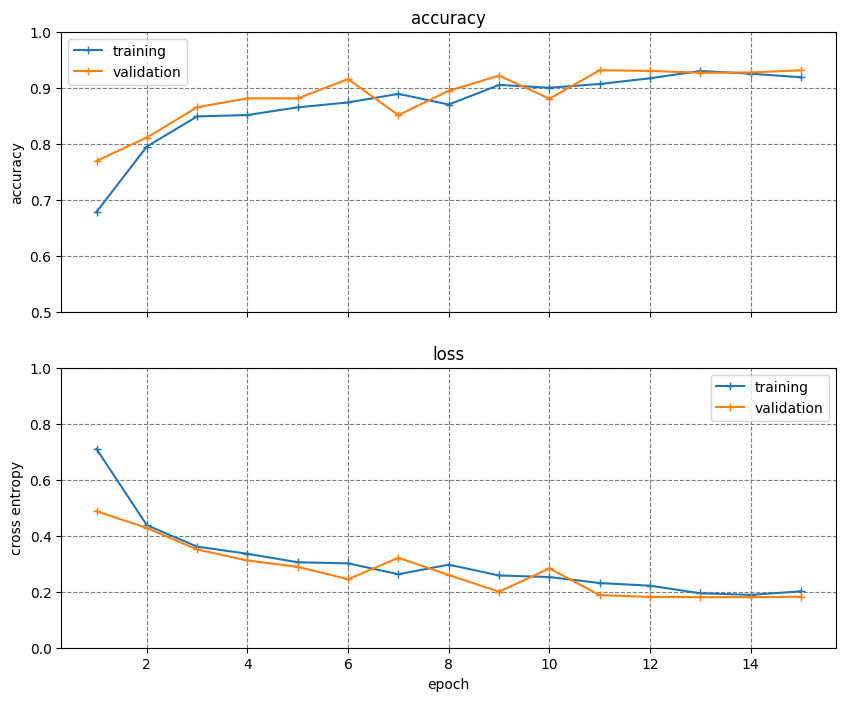

In [53]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,8), sharex=True)

x_plot = range(1, len(loss) + 1)

ax[0].plot(x_plot, acc, '+-', label='training')
ax[0].plot(x_plot, val_acc, '+-', label='validation')
ax[0].legend()
ax[0].set_ylabel('accuracy')
ax[0].set_ylim(0.5, 1)
ax[0].grid(ls='--', c='C7')
ax[0].set_title('accuracy')

ax[1].plot(x_plot, loss, '+-', label='training')
ax[1].plot(x_plot, val_loss, '+-', label='validation')
ax[1].legend()
ax[1].set_ylabel('cross entropy')
ax[1].set_ylim(0, 1)
ax[1].grid(ls='--', c='C7')
ax[1].set_title('loss')
ax[1].set_xlabel('epoch')

plt.show()